# Predicting fluxes on grid

To do:
* Need to mask NaNs in any variables at any time-step as fill-value with be non-sensical

In [1]:
import sys
import xarray as xr
import numpy as np
from joblib import load
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr, HiddenPrints

/home/547/cb3058/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36031,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:35983,Total threads: 16
Dashboard: /proxy/46875/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:32931,


## Analysis Parameters

In [3]:
var = 'GPP'
results_name='GPP_2003_2021.nc'
model_path = '/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_GPP_model.joblib'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2002-10_2021.nc'

## Open model

In [4]:
model = load(model_path).set_params(n_jobs=1)

## Open predictor data

In [5]:
data = xr.open_dataset(data_path)

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [6]:
mask = data.lai.isnull().all('time')

In [7]:
results = []

i=0
#start from 3 as these time-steps doesn't have rainfall lag values
for i in range(3, len(data.time)): 
    print(" {:03}/{:03}\r".format(i + 1, len(range(3, len(data.time)))), end="")
    with HiddenPrints():
        predicted = predict_xr(model,
                            data.isel(time=i),
                            proba=False,
                            clean=True,
                              ).compute()
    
    predicted = predicted.Predictions.where(~mask)
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)
    i+=1

In [8]:
ds = xr.concat(results, dim='time').sortby('time').rename(var)

In [9]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)

## Plot

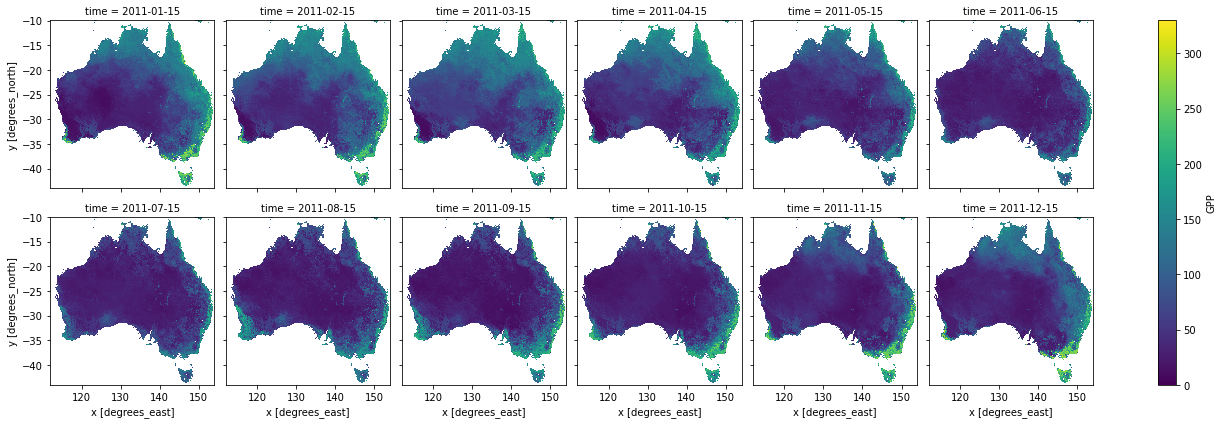

In [21]:
year='2011'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6, vmin=0);

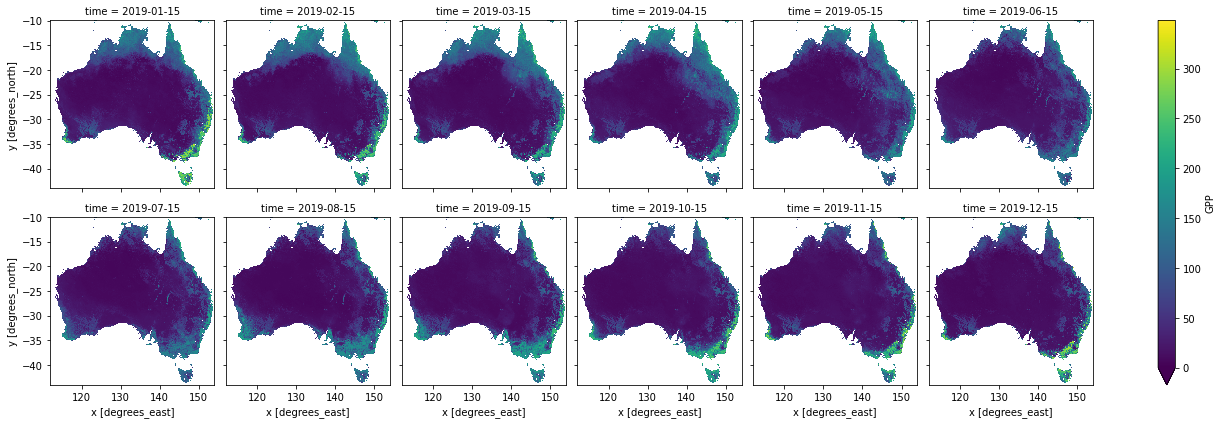

In [22]:
year='2019'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6, vmin=0);

In [10]:
ds_1D = ds.sum(['x','y'])

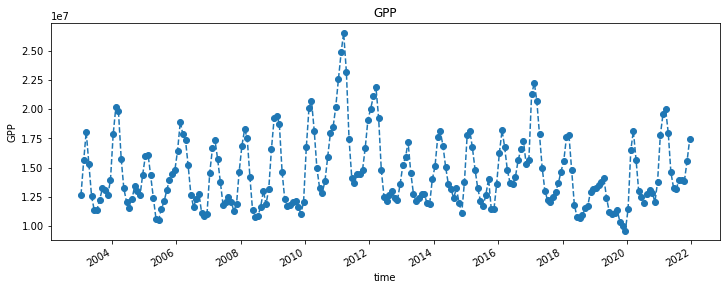

In [11]:
ds_1D.plot(figsize=(12,4), marker='o', linestyle='--')
plt.title(var);

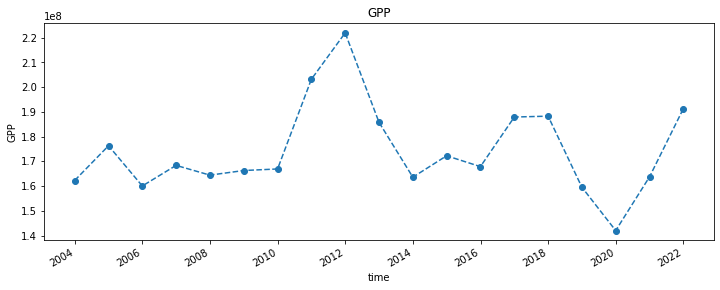

In [28]:
ds_1D_annual = ds_1D.resample(time='1Y').sum() 
ds_1D_annual.plot(figsize=(12,4), marker='o', linestyle='--')
plt.title(var);

In [26]:
1*1.0e15

1000000000000000.0